In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Layer
from tensorflow.keras.optimizers import RMSprop
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
import tensorflow as tf


Epoch 1/1, GGNN Loss: 28191.2477


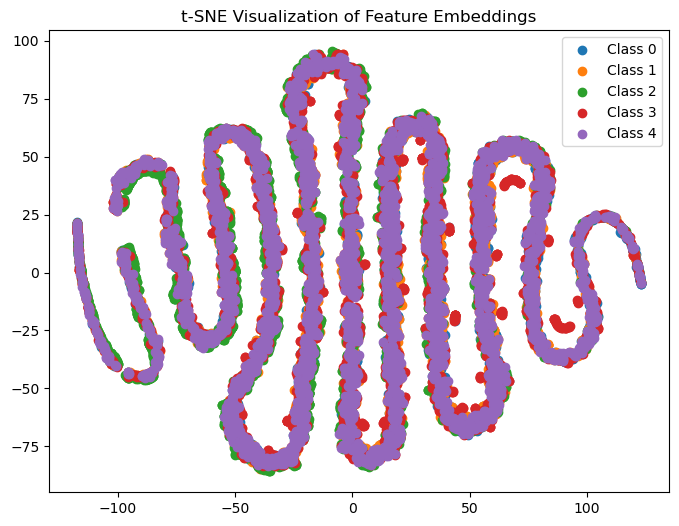

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GatedGraphConv
from gensim.models import Word2Vec
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

GRAPH_HIDDEN_DIM = 200
MLP_HIDDEN_SIZES = [256, 128, 256]
DROPOUT_PROB = 0.2
LEARNING_RATE = 0.0001
EPOCHS_GGNN = 1
EPOCHS_MLP = 1
TRIPLET_ALPHA = 0.5
TRIPLET_BETA = 0.001
TRIPLET_GAMMA = 0.5

class GGNNFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(GGNNFeatureExtractor, self).__init__()
        self.ggnn = GatedGraphConv(out_channels=hidden_dim, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout_prob)
        self.graph_fc = nn.Linear(hidden_dim, hidden_dim)
        self.activation = nn.Tanh()

    def forward(self, x, edge_index, batch):
        x = self.ggnn(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        graph_embedding = torch.zeros(batch.max().item() + 1, x.size(1)).to(x.device)
        graph_embedding.index_add_(0, batch, x)
        return self.graph_fc(graph_embedding)


class MLPRepresentationLearner(nn.Module):
    def __init__(self, input_dim, hidden_sizes, num_classes):
        super(MLPRepresentationLearner, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(DROPOUT_PROB))
            input_dim = hidden_size
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

def triplet_loss(logits, anchor_embed, positive_embed, negative_embed, alpha, beta, gamma):

    target_classes = torch.argmax(logits, dim=1)  
    cross_entropy_loss = nn.CrossEntropyLoss()(logits, target_classes)
    
    proj_loss = torch.clamp(
        torch.norm(anchor_embed - positive_embed, dim=1) - torch.norm(anchor_embed - negative_embed, dim=1) + gamma, 
        min=0
    ).mean()
    
    reg_loss = (anchor_embed.norm(dim=1) + positive_embed.norm(dim=1) + negative_embed.norm(dim=1)).mean()
    
    return cross_entropy_loss + alpha * proj_loss + beta * reg_loss



def visualize_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features.detach().cpu().numpy())
    plt.figure(figsize=(8, 6))
    for label in torch.unique(labels):
        indices = labels == label
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {label.item()}')
    plt.legend()
    plt.title("t-SNE Visualization of Feature Embeddings")
    plt.show()

def encode_node_features(nodes, word2vec_model):
    vectors = []
    for node in nodes:
        if node in word2vec_model.wv:
            vectors.append(torch.tensor(word2vec_model.wv[node], dtype=torch.float))
        else:
            vectors.append(torch.zeros(word2vec_model.vector_size, dtype=torch.float))
    return torch.stack(vectors)

def preprocess_dataset(df, word2vec_model):
    data_list = []
    for _, row in df.iterrows():
        nodes = row["functionSource"].split()
        edges = [[i, i + 1] for i in range(len(nodes) - 1)]
        label = row["numeric"]
        node_features = encode_node_features(nodes, word2vec_model)
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        data = Data(x=node_features, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
        data_list.append(data)
    return data_list

df = pd.read_csv('/Users/akter/Documents/MSR update/ICSME version/Train-Test daatset/Splited dataset/train_label_dataset.csv')
tokenized_funcs = [func.split() for func in df['functionSource']]
word2vec_model = Word2Vec(tokenized_funcs, vector_size=100, min_count=1)
data_list = preprocess_dataset(df, word2vec_model)

smote = SMOTE()
features = torch.cat([d.x.mean(dim=0).unsqueeze(0) for d in data_list], dim=0).numpy()
labels = torch.tensor([d.y.item() for d in data_list]).numpy()
features_balanced, labels_balanced = smote.fit_resample(features, labels)
data_balanced = [(torch.tensor(f, dtype=torch.float), torch.tensor(l, dtype=torch.long)) for f, l in zip(features_balanced, labels_balanced)]

ggnn = GGNNFeatureExtractor(input_dim=100, hidden_dim=GRAPH_HIDDEN_DIM, num_layers=8, dropout_prob=DROPOUT_PROB)
mlp = MLPRepresentationLearner(input_dim=GRAPH_HIDDEN_DIM, hidden_sizes=MLP_HIDDEN_SIZES, num_classes=len(set(labels)))
optimizer_ggnn = optim.Adam(ggnn.parameters(), lr=LEARNING_RATE)
optimizer_mlp = optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS_GGNN):
    ggnn.train()
    total_loss = 0
    for data in data_list:
        optimizer_ggnn.zero_grad()
        batch = torch.zeros(data.x.size(0), dtype=torch.long)
        output = ggnn(data.x, data.edge_index, batch)
        target = data.y
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer_ggnn.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{EPOCHS_GGNN}, GGNN Loss: {total_loss:.4f}")

features = torch.cat([ggnn(d.x, d.edge_index, torch.zeros(d.x.size(0), dtype=torch.long)) for d in data_list], dim=0)
visualize_tsne(features, torch.tensor(labels))

for epoch in range(EPOCHS_MLP):
    mlp.train()
    
    anchor_embed = features[:len(features) // 3]
    positive_embed = features[len(features) // 3: 2 * len(features) // 3]
    negative_embed = features[2 * len(features) // 3:]

    logits = mlp(features)

    loss = triplet_loss(
        logits=logits, 
        anchor_embed=anchor_embed, 
        positive_embed=positive_embed, 
        negative_embed=negative_embed, 
        alpha=TRIPLET_ALPHA, 
        beta=TRIPLET_BETA, 
        gamma=TRIPLET_GAMMA
    )

    optimizer_mlp.zero_grad()
    loss.backward()
    optimizer_mlp.step()



In [ ]:
def evaluate_model(ggnn, mlp, test_data_list):
    ggnn.eval()
    mlp.eval()
    total_correct = 0
    total_samples = 0
    predictions = []
    
    with torch.no_grad():
        for data in test_data_list:
            batch = torch.zeros(data.x.size(0), dtype=torch.long)
            graph_embedding = ggnn(data.x, data.edge_index, batch)
            logits = mlp(graph_embedding)
            predicted_classes = torch.argmax(logits, dim=1)
            predictions.extend(predicted_classes.tolist())
            total_correct += (predicted_classes == data.y).sum().item()
            total_samples += data.y.size(0)
    
    accuracy = total_correct / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")
    return predictions

train_df = pd.read_csv('/Users/akter/Documents/MSR update/ICSME version/Train-Test daatset/Splited dataset/train_label_dataset.csv')
test_df = pd.read_csv('/Users/akter/Documents/MSR update/ICSME version/Train-Test daatset/Splited dataset/test_label_dataset.csv')

train_tokenized_funcs = [func.split() for func in train_df['functionSource']]
test_tokenized_funcs = [func.split() for func in test_df['functionSource']]
word2vec_model = Word2Vec(train_tokenized_funcs + test_tokenized_funcs, vector_size=100, min_count=1)

train_data_list = preprocess_dataset(train_df, word2vec_model)
test_data_list = preprocess_dataset(test_df, word2vec_model)

smote = SMOTE()
train_features = torch.cat([d.x.mean(dim=0).unsqueeze(0) for d in train_data_list], dim=0).numpy()
train_labels = torch.tensor([d.y.item() for d in train_data_list]).numpy()
features_balanced, labels_balanced = smote.fit_resample(train_features, train_labels)
data_balanced = [(torch.tensor(f, dtype=torch.float), torch.tensor(l, dtype=torch.long)) for f, l in zip(features_balanced, labels_balanced)]

ggnn = GGNNFeatureExtractor(input_dim=100, hidden_dim=GRAPH_HIDDEN_DIM, num_layers=8, dropout_prob=DROPOUT_PROB)
mlp = MLPRepresentationLearner(input_dim=GRAPH_HIDDEN_DIM, hidden_sizes=MLP_HIDDEN_SIZES, num_classes=5)
optimizer_ggnn = optim.Adam(ggnn.parameters(), lr=LEARNING_RATE)
optimizer_mlp = optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS_GGNN):
    ggnn.train()
    total_loss = 0
    for data in train_data_list:
        optimizer_ggnn.zero_grad()
        batch = torch.zeros(data.x.size(0), dtype=torch.long)
        output = ggnn(data.x, data.edge_index, batch)
        target = data.y
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer_ggnn.step()
        total_loss += loss.item()
    

train_features = torch.cat([ggnn(d.x, d.edge_index, torch.zeros(d.x.size(0), dtype=torch.long)) for d in train_data_list], dim=0)

for epoch in range(EPOCHS_MLP):
    mlp.train()
    anchor_embed = train_features[:len(train_features) // 3]
    positive_embed = train_features[len(train_features) // 3: 2 * len(train_features) // 3]
    negative_embed = train_features[2 * len(train_features) // 3:]

    logits = mlp(train_features)

    loss = triplet_loss(
        logits=logits, 
        anchor_embed=anchor_embed, 
        positive_embed=positive_embed, 
        negative_embed=negative_embed, 
        alpha=TRIPLET_ALPHA, 
        beta=TRIPLET_BETA, 
        gamma=TRIPLET_GAMMA
    )

    optimizer_mlp.zero_grad()
    loss.backward()
    optimizer_mlp.step()

    print(f"Epoch {epoch + 1}/{EPOCHS_MLP}, MLP Loss: {loss.item():.4f}")

test_features = torch.cat([ggnn(d.x, d.edge_index, torch.zeros(d.x.size(0), dtype=torch.long)) for d in test_data_list], dim=0)

predictions = evaluate_model(ggnn, mlp, test_data_list)

for i, pred in enumerate(predictions):
    print(f"Test Sample {i + 1}: Predicted Class = {pred}")


from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    matthews_corrcoef,
    cohen_kappa_score
)

test_labels = torch.cat([data.y for data in test_data_list]).cpu().numpy()
predicted_labels = evaluate_model(ggnn, mlp, test_data_list)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, predicted_labels))

accuracy = accuracy_score(test_labels, predicted_labels)
precision_macro = precision_score(test_labels, predicted_labels, average="macro", zero_division=0)
recall_macro = recall_score(test_labels, predicted_labels, average="macro", zero_division=0)
f1_macro = f1_score(test_labels, predicted_labels, average="macro", zero_division=0)

precision_weighted = precision_score(test_labels, predicted_labels, average="weighted", zero_division=0)
recall_weighted = recall_score(test_labels, predicted_labels, average="weighted", zero_division=0)
f1_weighted = f1_score(test_labels, predicted_labels, average="weighted", zero_division=0)

mcc = matthews_corrcoef(test_labels, predicted_labels)
cohen_kappa = cohen_kappa_score(test_labels, predicted_labels)

roc_auc_macro = roc_auc_score(
    pd.get_dummies(test_labels), pd.get_dummies(predicted_labels), average="macro", multi_class="ovr"
)

mse = mean_squared_error(test_labels, predicted_labels)
mae = mean_absolute_error(test_labels, predicted_labels)

print(f"\nAccuracy: {accuracy:.3f}")
print(f"Precision (Macro): {precision_macro:.3f}")
print(f"Recall (Macro): {recall_macro:.3f}")
print(f"F1 Score (Macro): {f1_macro:.3f}")
print(f"Precision (Weighted): {precision_weighted:.3f}")
print(f"Recall (Weighted): {recall_weighted:.3f}")
print(f"F1 Score (Weighted): {f1_weighted:.3f}")
print(f"Matthews Correlation Coefficient: {mcc:.3f}")
print(f"Cohen's Kappa Score: {cohen_kappa:.3f}")
print(f"ROC AUC Score (Macro): {roc_auc_macro:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")


In [ ]:

metrics_dict = {
    "Metric": [
        "Accuracy",
        "Precision (Macro)",
        "Recall (Macro)",
        "F1 Score (Macro)",
        "Precision (Weighted)",
        "Recall (Weighted)",
        "F1 Score (Weighted)",
        "Matthews Correlation Coefficient",
        "Cohen's Kappa Score",
        "ROC AUC Score (Macro)",
        "Mean Squared Error (MSE)",
        "Mean Absolute Error (MAE)"
    ],
    "Value": [
        accuracy,
        precision_macro,
        recall_macro,
        f1_macro,
        precision_weighted,
        recall_weighted,
        f1_weighted,
        mcc,
        cohen_kappa,
        roc_auc_macro,
        mse,
        mae
    ]
}

metrics_df = pd.DataFrame(metrics_dict)

csv_filename = "model_evaluation_metrics.csv"
metrics_df.to_csv(csv_filename, index=False)

print(f"Metrics saved to {csv_filename}")

print(metrics_df)


In [17]:

metrics_df.to_csv("/Users/akter/Documents/MSR update/ICSME version//All Embeddings dataset/SOTA extracted dataset/SOTA_performances/ReVEAL.csv", index=False)